# Predict stock prices with a RNN

## Parameters

In [ ]:
#For fetching the data
TICKER = "UBER"
FECHA_INICIAL = "2020-11-15"
FECHA_FINAL = "2021-03-26"
PRECIO = "Close"
PERIODO = "1d" 

In [ ]:
#For building/training the model
TRAIN_PERC = 0.85
WINDOW = 5
EPOCHS = 700
LEARNING = 0.0006
CHECK_AT = 100

## Import

In [ ]:
#!pip install yfinance
import yfinance as yf
data = yf.download(TICKER, period=PERIODO, start=FECHA_INICIAL, end=FECHA_FINAL)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-16,48.740002,50.090000,48.480000,49.209999,49.209999,29301700
2020-11-17,48.720001,49.619999,48.500000,48.889999,48.889999,16638300
2020-11-18,48.770000,49.950001,48.330002,49.110001,49.110001,17783500
2020-11-19,49.099998,49.910000,48.650002,49.259998,49.259998,13480300
2020-11-20,49.980000,50.750000,48.270000,48.430000,48.430000,17330400


## Graphs

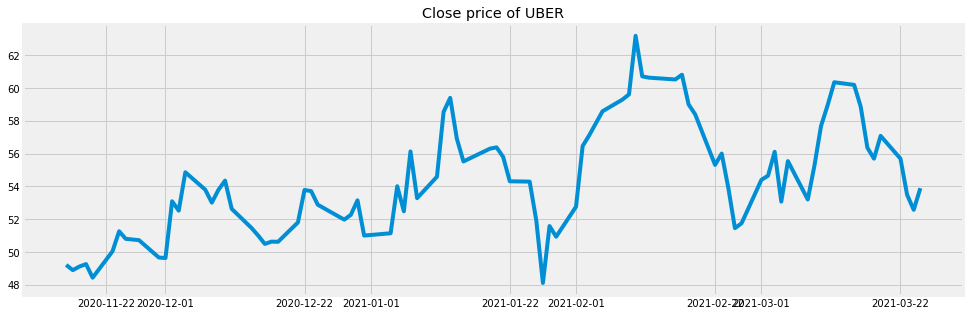

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pandas.plotting import register_matplotlib_converters
%matplotlib inline

def line_stock(df):
  fig_size = 15,5
  plt.rcParams["figure.figsize"] = fig_size
  plt.title(f'{PRECIO}-price of {TICKER}')
  plt.plot(df);

line_stock(data[[PRECIO]])

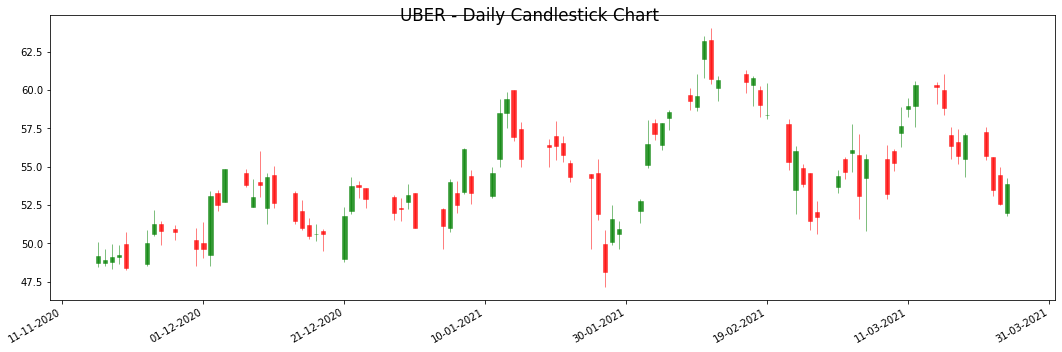

In [ ]:
#!pip install mpl_finance
import pandas as pd
import matplotlib.dates as mpl_dates
from mpl_finance import candlestick_ohlc

def pro_price(df):
  ohlc = df.reset_index().loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
  ohlc['Date'] = pd.to_datetime(ohlc['Date'])
  ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
  ohlc = ohlc.astype(float)

  fig, ax = plt.subplots()
  plt.style.use('fivethirtyeight')
  candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
  fig.suptitle(f'{TICKER} - Daily Candlestick Chart')
  date_format = mpl_dates.DateFormatter('%d-%m-%Y')
  ax.xaxis.set_major_formatter(date_format)
  fig.autofmt_xdate()
  fig.tight_layout()
  plt.show();

pro_price(data)

## Feature engineering

In [ ]:
df = data[[PRECIO]]

#Keep the first 70% of the rows for training
limite = int(len(df)*TRAIN_PERC)
df_train = df.iloc[:limite,:]
df_test = df.iloc[limite:,:]

print(df_train.tail())
print(df_test.head())

                Close
Date                 
2021-03-01  54.400002
2021-03-02  54.650002
2021-03-03  56.110001
2021-03-04  53.070000
2021-03-05  55.540001
                Close
Date                 
2021-03-08  53.200001
2021-03-09  55.250000
2021-03-10  57.680000
2021-03-11  58.950001
2021-03-12  60.349998


In [ ]:
from sklearn.preprocessing import MinMaxScaler

#Scale the prices for un-biased predictions
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled = pd.DataFrame(scaler.fit_transform(df_train), index=df_train.index, columns=df_train.columns)
df_scaled.describe()

,Close
count,75.000000
mean,-0.220916
std,0.457301
min,-1.000000
25%,-0.569343
50%,-0.256802
75%,0.063039
max,1.000000


In [ ]:
from torch import FloatTensor

#Break the whole time-series in windows of "n" size with their next value as "prediction"
def secuencias_inout(input, n=WINDOW):
    input = FloatTensor(input).view(-1) 
    aux = []
    for i in range(len(input) - n):
      aux.append((input[i:i+n], input[i+n:i+n+1]))
    
    return aux

secuencias = secuencias_inout(df_scaled.values)
#An example:
secuencias_inout(range(8), n=3)

[(tensor([0., 1., 2.]), tensor([3.])),
 (tensor([1., 2., 3.]), tensor([4.])),
 (tensor([2., 3., 4.]), tensor([5.])),
 (tensor([3., 4., 5.]), tensor([6.])),
 (tensor([4., 5., 6.]), tensor([7.]))]

## Arquitecture

In [ ]:
import torch
import torch.nn as nn

class StockRNN(nn.Module):
    ########################### WHAT DOES 100 MEAN?
    def __init__(self, entrada_size=1, actual_size=100, salida_size=1):
        #Inherit __init__ from nn.Module
        super(StockRNN, self).__init__()
            
        self.actual_size = actual_size
        #The first matrix is going to be one input (date) of shape 1 x actual_size
        self.matriz_actual = (torch.zeros(1, 1, self.actual_size),
                              ########################### WHY THIS LINE IS TWICE?
                              torch.zeros(1, 1, self.actual_size))
          
        #Long-Short Term Memory for avoiding exploding Gradient
        self.lstm = nn.LSTM(entrada_size, actual_size)
        #A Linear is needed to predict
        self.linear = nn.Linear(actual_size, salida_size)

    def forward(self, secuencia):
        ########################### "MATRIZ_ACTUAL" IS OVERWRITTEN, WHY?
        lstm_out, self.matriz_actual = self.lstm(secuencia.view(len(secuencia),1,-1), #Being recursive means the sequence lenght will increase
                                                self.matriz_actual)
        ########################### IS IT JUST ONE NEURON TO PREDICT?
        predicciones = self.linear(lstm_out.view(len(secuencia), -1))     
        return predicciones[-1]

In [ ]:
stonks = StockRNN()
#Do not change any parameter of the RNN
with torch.no_grad(): prediction = stonks.forward(secuencias[0][0])
#Reverse the scale of the prediction to meet the actual prediction value
scaler.inverse_transform(prediction.numpy().reshape(-1,1))

array([[56.166954]], dtype=float32)

## Training

In [ ]:
import time
import numpy as np

def time_exp(x):
    return f'{int(np.floor(x/60))}min {round(60*(x/60-np.floor(x/60)),1)}sec'

loss_function = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(stonks.parameters(), lr=LEARNING)

errores = [] 
start = time.time()
for i in range(EPOCHS):
    for seq, labels in secuencias:
        #Clear out the gradients of previous calculation
        optimizer.zero_grad()
        stonks.matriz_actual = (torch.zeros(1, 1, stonks.actual_size),
                                torch.zeros(1, 1, stonks.actual_size))
        #Prediction over the sequence
        y_pred = stonks(seq)    
        
        loss = loss_function(y_pred, labels)
        #Backprop
        loss.backward()
        #Update parameters
        optimizer.step()

    #Show the cumulative loss
    if i % CHECK_AT == CHECK_AT-1:
        print(f'At epoch {i+1} in {time_exp(time.time()-start)}, loss is {loss.item():10.8f}')
    errores.append(loss)

At epoch 100 in 0min 12.7sec, loss is 0.06193585
At epoch 200 in 0min 25.3sec, loss is 0.03415589
At epoch 300 in 0min 39.3sec, loss is 0.00036421
At epoch 400 in 0min 52.8sec, loss is 0.00223451
At epoch 500 in 1min 5.3sec, loss is 0.00005940
At epoch 600 in 1min 17.8sec, loss is 0.00009493
At epoch 700 in 1min 30.5sec, loss is 0.00000478


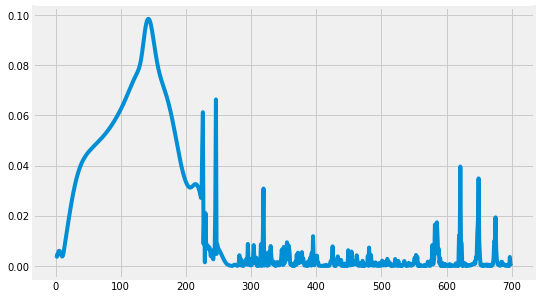

In [ ]:
figure(num=None, figsize=(8,5), facecolor='w', edgecolor='k')
plt.plot(range(len(errores)), errores)
plt.show();

## Test

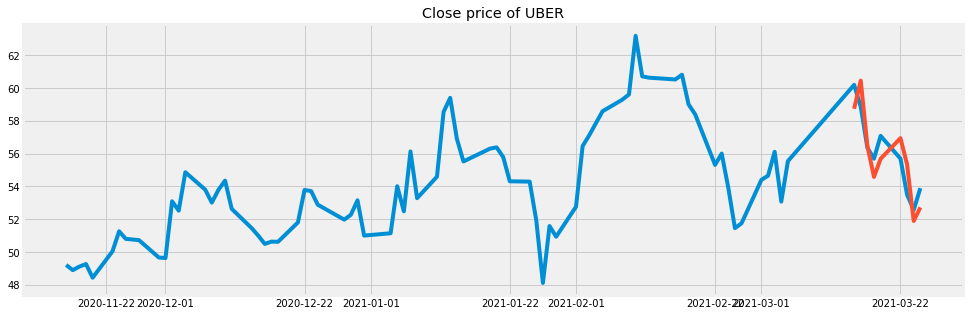

In [ ]:
def validar(df,modelo,df_real):
  test_scaled = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
  seq_val = secuencias_inout(test_scaled.values)

  estimated = []
  for i,_ in enumerate(seq_val):
    with torch.no_grad():
        modelo.matriz = (torch.zeros(1,1,modelo.actual_size),
                         torch.zeros(1,1,modelo.actual_size))
        scaled_pred = modelo(seq_val[i][0])
        pred = scaler.inverse_transform(scaled_pred.numpy().reshape(-1, 1))[0][0]
    estimated.append(pred)

  aux = df.iloc[WINDOW:,:].copy()
  aux['Estimated'] = estimated
  return df_real.append(aux)

line_stock(validar(df_test,stonks,df_train))